In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [3]:
def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)

        if 0.1 * i == 0.5:
            continue

        inputs.append([0.1 * i, 1 - 0.1*i])
        labels.append(1)        

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [4]:
def plot_data(X, y, pred_y, save_img_name):
    print("Acc: ", 1 - np.mean(abs(y - pred_y)))
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 10))
    color_real = ['red' if l == 0 else 'green' for l in y]
    color_pred = ['red' if l == 0 else 'green' for l in pred_y]
    
    ax[0].scatter(X[:, 0], X[:, 1], color=color_real)
    ax[0].set_aspect("equal")
    ax[0].title.set_text("real")

    ax[1].scatter(X[:, 0], X[:, 1], color=color_pred)
    ax[1].title.set_text("predict")
    ax[1].set_aspect("equal")
    plt.savefig(save_img_name)
    plt.show()

In [5]:
class Model():
    # input is 3d(x, y coordinate + 1 for bias), output is 1d
    # 2 hidden layer, 2 neurons for each
    class Layer():
        def __init__(self, size):
            self.d_a_hat = 0
            self.d_a = 0
            self.W = np.random.random(size) * np.sqrt(2 / size[1])
            self.b = np.zeros((1, size[1]))
            self.a_hat = 0
            self.Wm = np.zeros(size)
            self.bm = np.zeros((1, size[1]))
                        
    def __init__(self):
        self.layer = []
    
    def add_layer(self, size):
        l = self.Layer(size)
        self.layer.append(l)
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def derivative_sigmoid(self, x):
        return np.multiply(x, 1.0 - x)
    
    def cal_loss(self, y, pred_y):
        # using cross entropy
#         return (1/2) * np.mean(sum(pow(pred_y - y, 2)))
        return np.mean(-(y * np.log(pred_y) + (1 - y) * np.log(1 - pred_y)))
    
    
    def derivative_loss(self, y, pred_y, batch_size):
#         return (pred_y - y) / batch_size
        return ((-y / pred_y) + (1 - y) / (1 - pred_y))/batch_size
    
    def update_W(self, x, y, pred_y, lr, batch_size):
        num_layer = len(self.layer)
        for i in range(num_layer)[::-1]:
            cur_layer = self.layer[i]
            if i == num_layer - 1:
                cur_layer.d_a_hat = self.derivative_loss(y, pred_y, batch_size)
            else:
                cur_layer.d_a_hat = self.layer[i+1].d_a @ self.layer[i+1].W.T
            cur_layer.d_a = cur_layer.d_a_hat * self.derivative_sigmoid(cur_layer.a_hat)
                         
        for i in range(num_layer):
            cur_layer = self.layer[i]
            if i == 0:
                grad = -lr * np.atleast_2d(x).T @ cur_layer.d_a
            else:
                grad = -lr * self.layer[i-1].a_hat.T @ cur_layer.d_a
            cur_layer.W += grad + cur_layer.Wm
            cur_layer.Wm = cur_layer.Wm * 0.99 + grad * 0.01
            
            grad_b = -lr * (np.mean(cur_layer.d_a, axis=0))
            cur_layer.b += grad_b + cur_layer.bm
            cur_layer.bm = cur_layer.bm * 0.99 + grad_b * 0.01
            
    
    def preprocess_x(self, X_train):
        # add bias term
        X_train = np.hstack((X_train, np.ones(X_train.shape[0]).reshape(-1, 1)))
        return X_train
        
    def train(self, X_train, y_train, lr, batch_size=5, iteration=100):        
        loss_acc = []
        batch = list(range(0, X_train.shape[0], batch_size))
        if batch[-1] != X_train.shape[0]:
            batch.append(X_train.shape[0])
        
        for i in range(iteration):
            pred_y = []
            for k in range(len(batch)-1):
                x = X_train[batch[k]:batch[k+1]]
                y = y_train[batch[k]:batch[k+1]]
                in_data = np.atleast_2d(x)
                for j in range(len(self.layer)):
                    self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                    in_data = self.layer[j].a_hat
                        
                y_hat = in_data
                loss = self.cal_loss(y, y_hat)
                self.update_W(x, y, y_hat, lr, batch_size)
                pred_y.extend(y_hat)
            
            pred_y = np.array(pred_y)
            loss = np.mean(self.cal_loss(y_train, pred_y))
            loss_acc.append(loss)
            if i % 5000 == 0:
                print("epoch", i, ":", loss)
                
        return loss_acc
        
    def predict(self, X):
        pred_y = []
        for x in X:
            in_data = np.atleast_2d(x)
            for j in range(len(self.layer)):
                self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                in_data = self.layer[j].a_hat

            pred_y.extend(in_data)
        return np.round(np.array(pred_y)), np.array(pred_y)

In [6]:
def shuffle(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

epoch 0 : 0.8632785311267122
epoch 5000 : 0.0026152420034839027
epoch 10000 : 0.0009687452909489499
epoch 15000 : 0.0005630398591876329
prediction:
 [[9.99993670e-01 1.26857377e-05 7.79077476e-06 7.10408466e-06]
 [7.29206582e-06 1.08005978e-05 9.99993868e-01 9.99993875e-01]
 [7.10259174e-06 3.00407765e-04 7.52110822e-06 1.73777869e-03]
 [7.51777968e-06 9.99992729e-01 7.56014713e-06 7.94527788e-06]
 [9.99993862e-01 9.99993872e-01 9.99993869e-01 7.79857273e-06]
 [9.99992662e-01 9.99993841e-01 7.76054901e-06 9.99933418e-01]
 [9.61031734e-06 8.76489916e-06 7.12533853e-06 9.99993852e-01]
 [1.04137123e-04 7.64889393e-06 9.99992022e-01 7.51092441e-06]
 [1.03847283e-05 9.99993801e-01 7.16377970e-06 9.99254094e-01]
 [9.99993761e-01 1.66638480e-03 7.09930083e-06 7.55030866e-06]
 [7.24080258e-06 9.99993882e-01 7.10341916e-06 9.98819513e-01]
 [9.99993270e-01 9.99986423e-01 7.36276596e-06 7.10814305e-06]
 [1.40645088e-05 7.12596251e-06 9.99993869e-01 9.99993869e-01]
 [9.99993850e-01 7.39891305e-06 

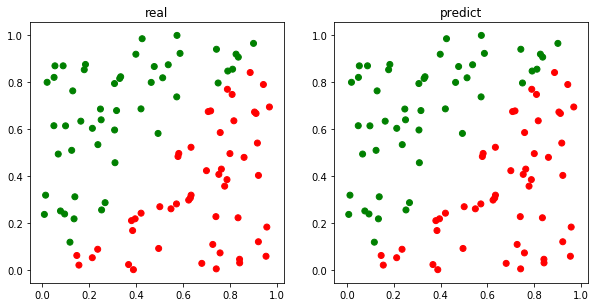

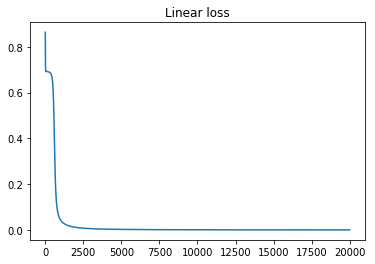

In [7]:
print("Linear data:")
lr = 0.3
batch_size=100
X, y = generate_linear()
X, y = shuffle(X, y)
m = Model()
m.add_layer((2, 2))
m.add_layer((2, 2))
m.add_layer((2, 1))
loss = m.train(X, y, lr, batch_size, iteration=20000)
pred_y, pred_y_raw = m.predict(X)
print("prediction:\n", pred_y_raw.reshape(-1, 4))
plot_data(X, y, pred_y, "linear_pred.png")
plt.plot(loss)
plt.title("Linear loss")
plt.savefig("linear_loss.png")
plt.show()

epoch 0 : 0.894160021387828
epoch 5000 : 0.6919279222029155
epoch 10000 : 0.018325346129717954
epoch 15000 : 0.0013142370259128454
epoch 20000 : 0.0005888163812897248
epoch 25000 : 0.0003662706935775404
epoch 30000 : 0.00026172859254822265
epoch 35000 : 0.00020188900792663582
epoch 40000 : 0.00016345152595857428
epoch 45000 : 0.0001368180716245431
epoch 50000 : 0.00011734647295372655
epoch 55000 : 0.00010252986647924986
epoch 60000 : 9.090068540987702e-05
epoch 65000 : 8.154501001663965e-05
epoch 70000 : 7.386517369072345e-05
epoch 75000 : 6.745449871491718e-05
epoch 80000 : 6.202701409303618e-05
epoch 85000 : 5.7375982079616786e-05
epoch 90000 : 5.334836912087918e-05
epoch 95000 : 4.9828557118343454e-05
prediction:
 [1.34490538e-04 9.99999547e-01 2.32751072e-06 2.01067739e-08
 9.99999565e-01 1.21133329e-06 9.99999584e-01 9.99999291e-01
 3.51841394e-08 9.99999582e-01 9.99999343e-01 2.00576822e-04
 1.85969179e-05 7.18280157e-05 9.99999529e-01 9.99999549e-01
 5.71913781e-06 9.99731962e-0

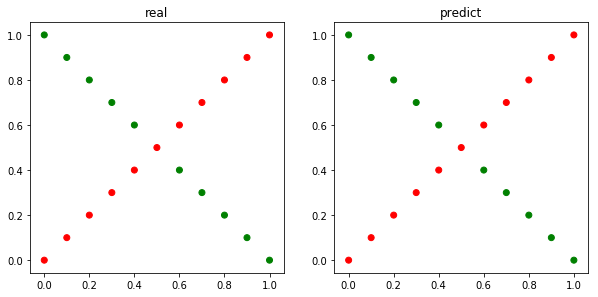

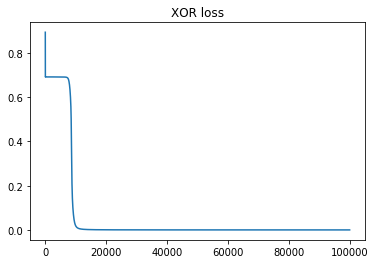

In [8]:
print("XOR data:")
lr = 0.3
X, y = generate_XOR_easy()
X, y = shuffle(X, y)
m = Model()
m.add_layer((2, 3))
m.add_layer((3, 3))
m.add_layer((3, 1))
loss = m.train(X, y, lr, batch_size=21, iteration=100000)
pred_y, pred_y_raw = m.predict(X)
print("prediction:\n", pred_y_raw.flatten())
plot_data(X, y, pred_y, "XOR_pred.png")
plt.plot(loss)
plt.title("XOR loss")
plt.savefig("XOR_loss.png")
plt.show()